## snippets

## Detect psf

In [ ]:
# centroid positions of the regions
from mophongo.psf import DrizzlePSF
from mophongo.psf_map import PSFRegionMap
import mophongo.utils as utils

psf_dir = data_dir / 'PSF'
stpsf_444 = 'UDS_NRC.._F444W_OS4_GRID25'
stpsf_770 = 'UDS_MIRI_F770W_OS4_GRID9'
size = 101

pos770 = [np.squeeze(p.xy) for p in prm_770.regions.geometry.centroid]

# load webb psfs
#dpsf_444.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_444)
dpsf_770.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_770)

# drizzle at centroid positions
#prm_444.psfs = dpsf_444.get_psf_radec(pos, size=size)
prm_770.psfs = dpsf_770.get_psf_radec(pos770, size=size)

from matplotlib import pyplot as plt
from astropy.stats import mad_std
s = mad_std(prm_770.psfs[0])*20
plt.imshow(prm_770.psfs[0],vmin=-s, vmax=s, origin='lower')

# st

### quick Catalog

In [ ]:
import os
import sys
current = os.getcwd()
sys.path.insert(0, os.path.join(current, "..", "src"))
sys.path.insert(0, current)
from pathlib import Path
from astropy.io import fits
from mophongo.psf_map import PSFRegionMap
from mophongo.fit import FitConfig
from mophongo.catalog import Catalog
from mophongo import pipeline
from mophongo import Templates


data_dir = Path('../data')
field = 'uds-test'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
# supposed in units of inverse variance -> rms = 1/sqrt(wht)
wht_444 = data_dir / f'{field}-f444w_wht.fits'

prm_kern = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_kernel_f770w.geojson'))
prm_444 = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_psf.geojson'))
prm_770 = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f770w_psf.geojson'))

# MIRI images
img_770 = fits.getdata(data_dir / f'{field}-f770w_sci.fits')
wht_770 = fits.getdata(data_dir / f'{field}-f770w_wht.fits')

# create new catalog from 444
cat444 = Catalog.from_fits(sci_444, wht_444, estimate_ivar=True)


## templates

In [ ]:
pos = [(x,y) for x,y, in cat444.table['x','y']]
templates = Templates.from_image(cat444.sci,
                     cat444.segmap.data,
                     pos,
                     kernel=None)

from matplotlib import pyplot as plt
from astropy.stats import mad_std
import numpy as np
i = 2
s = np.std(templates[i].data)*3
plt.imshow(templates[i].data, origin='lower', vmin=-s, vmax=s, cmap='gray')
#plt.imshow(templates[i].data==0, origin='lower', vmin=-s, vmax=s, cmap='gray')
s

Drizzling PSFs: 100%|██████████| 1470/1470 [00:22<00:00, 64.62it/s]
Kernel contains non-finite values, returning zero kernel.


In [23]:
xy = dpsf_770.driz_wcs.wcs_world2pix(pos, 0)
xy.min(axis=0), xy.max(axis=0), dpsf_770.driz_wcs
prm_kern.regions,prm_kern.psfs, prm_444.psfs, prm_770.psfs

(      psf_key_1  psf_key_2  psf_key  \
 0             0        111        0   
 1             0        112        1   
 2             0        114        2   
 3             0        117        3   
 4             1        102        4   
 ...         ...        ...      ...   
 1465        832         94     1465   
 1466        833         94     1466   
 1467        834         88     1467   
 1468        834         89     1468   
 1469        834         90     1469   
 
                                                geometry  
 0     POLYGON ((34.21778 -5.14319, 34.21792 -5.14319...  
 1     POLYGON ((34.22194 -5.15403, 34.22181 -5.15403...  
 2     POLYGON ((34.21875 -5.14528, 34.21722 -5.14569...  
 3     POLYGON ((34.22028 -5.15625, 34.22014 -5.15583...  
 4     POLYGON ((34.23847 -5.11806, 34.23861 -5.11806...  
 ...                                                 ...  
 1465  POLYGON ((34.27431 -5.10653, 34.27319 -5.10694...  
 1466  POLYGON ((34.30444 -5.11472, 34.30583 -

In [13]:
# dpsf_444.driz_pscale, dpsf_770.driz_pscale, dpsf_770.driz_wcs.pscale
# #utils.get_wcs_pscale(dpsf_444.driz_wcs), utils.get_wcs_pscale(dpsf_770.driz_wcs)
# from matplotlib import pyplot as plt
# plt.imshow(prm_770.psfs[0],vmin=-0.001, vmax=0.001, origin='lower', cmap='gray')
# fac = round(dpsf_770.driz_pscale/dpsf_444.driz_pscale)
# pz = zoom(prm_770.psfs[0], fac, order=3, prefilter=True)

# plt.imshow(pz,vmin=-0.001, vmax=0.001, origin='lower', cmap='gray')
# from scipy.ndimage import zoom
# plt.imshow(prm_444.psfs[0],vmin=-0.001, vmax=0.001, origin='lower', cmap='gray')
# plt.imshow(k0,vmin=-0.001, vmax=0.001, origin='lower', cmap='gray')

## Run photometry

In [25]:
from pathlib import Path
from astropy.io import fits
from mophongo.psf_map import PSFRegionMap
from mophongo.fit import FitConfig
from mophongo.catalog import Catalog
from mophongo import pipeline

data_dir = Path('../data')
#field = 'uds-test'
#field = 'uds-medium'
#field = 'uds-large'
field = 'uds-half'

field_miri = field+'-80mas'
#field_miri = field 

prm_444 = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_psf.geojson'))
prm_770 = PSFRegionMap.from_geojson(str(data_dir / f'{field_miri}-f770w_psf.geojson'))
prm_kern = PSFRegionMap.from_geojson(str(data_dir / f'{field_miri}-f444w_kernel_f770w.geojson'))

sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'

# read in LW selected catalog
seg_LW = data_dir / f'{field}-LW_seg.fits'
cat444 = Catalog.from_fits(sci_444, wht_444, segmap=seg_LW, estimate_ivar=True)

# MIRI images
field_miri = field+'-80mas'
sci_770 = data_dir / f'{field_miri}-f770w_sci.fits'
wht_770 = data_dir / f'{field_miri}-f770w_wht.fits'

cat770 = Catalog.from_fits(sci_770, wht_770, estimate_ivar=True)

residual = [None, None, None, None]

Measuring inverse variance map...
Measuring inverse variance map...
Convolving with kernel size 3.5 pixels
Detecting sources...
Dilating segmentation map with size 2


In [26]:
# MIRI images
#from astropy.wcs import WCS
# img_770 = fits.getdata(data_dir / f'{field}-80mas-f770w_sci.fits')
# wht_770 = fits.getdata(data_dir / f'{field}-80mas-f770w_wht.fits')
# hdr_770 = fits.getheader(data_dir / f'{field}-80mas-f770w_sci.fits')
# w = cat770.ivar
# ivar_770 = 1 / ((1 / w).reshape(w.shape[0]//2, 2, w.shape[1]//2, 2).sum(axis=(1, 3)))

# first fit, no shifts: first image is template, 2nd and on the fitting images
table, res0, fit0 = pipeline.run([cat444.sci, cat770.sci], cat444.segmap.data,
                                weights=[cat444.ivar, cat770.ivar],
                                catalog=cat444.table,
                                psfs=[prm_444, prm_770],
                                kernels=[None, prm_kern],
                                wcs=[cat444.wcs, cat770.wcs],
                                config=FitConfig(fit_astrometry_niter=0))
residual[0] = res0[0]
#fits.writeto('residual_noshift.fits', data=residual[0], overwrite=True)
#fits.writeto('model_noshift.fits', data=cat770.sci-residual[0], overwrite=True)

Pipeline (start) memory: 13.0 GB
Pipeline config: FitConfig(positivity=False, reg=0.0, bad_value=nan, solve_method='ata', cg_kwargs={'M': None, 'maxiter': 500, 'atol': 1e-06}, fit_covariances=False, fft_fast=False, fit_astrometry_niter=0, fit_astrometry_joint=False, reg_astrom=0.0001, snr_thresh_astrom=10.0, astrom_model='gp', astrom_centroid='centroid', astrom_kwargs={'poly': {'order': 2}, 'gp': {'length_scale': 500}}, multi_tmpl_chi2_thresh=5.0, multi_tmpl_psf_core=True, multi_tmpl_colour=False, normal='tree')


Extracting templates: 100%|██████████| 73021/73021 [01:37<00:00, 747.48it/s]


Pipepline: 72861 extracted templates, dropped 160.
Pipeline (templates) memory: 14.2 GB
binning factor: 2
upsampling image 1 by factor 2
Using kernel lookup table uds-half-80mas-f444w_kernel_f770w
Pruned 22554 templates outside weight map


Convolving templates: 100%|██████████| 50307/50307 [00:22<00:00, 2270.19it/s]


Pipeline (convolved) memory: 11.3 GB
Running iteration 1 of 1


Building Normal matrix: 100%|██████████| 50224/50224 [00:03<00:00, 13874.19it/s]


Pipeline (residual) memory: 13.1 GB


Building Normal matrix: 100%|██████████| 50224/50224 [00:03<00:00, 13874.18it/s]


Distribution >99% chi2: [3.85899734]
Adding 431 new templates for poor fits (chi^2/nu > 5.0)


Building Normal matrix: 100%|██████████| 50653/50653 [00:03<00:00, 12943.80it/s]


Done...
Downsampling residuals by factor 2
Pipeline (end) memory: 11.8 GB


In [3]:
#%%timeit 
# fit0.build_normal_matrix()
# ata_loop = fit0._ata 
# fit0._ata = None
# fit0.build_normal_tree()
# ata_tree = fit0._ata 
# (ata_loop[0:3].data == ata_tree[0:3].data).all()
#fit0.templates
#import numpy as np


### Separate flux and astrometric fit

First fit fluxes, then astrometric shift field, iterate.

In [27]:
# test astrometry fit vs number of iterations for separate astro + flux fits
config = FitConfig(fit_astrometry_niter=3, fit_astrometry_joint=False)
table1, res1, fit1 = pipeline.run([cat444.sci, cat770.sci],
                                cat444.segmap.data,
                                weights=[cat444.ivar, cat770.ivar],
                                catalog=cat444.table,  
                                psfs=[prm_444, prm_770],
                                kernels=[None, prm_kern],
                                wcs=[cat444.wcs, cat770.wcs],
                                config=config)
residual[1] = res1[0]
#fits.writeto('residual_separate.fits', data=residual[1], overwrite=True)
#fits.writeto('model_separate.fits', data=cat770.sci-residual[1], overwrite=True)

Pipeline (start) memory: 12.6 GB
Pipeline config: FitConfig(positivity=False, reg=0.0, bad_value=nan, solve_method='ata', cg_kwargs={'M': None, 'maxiter': 500, 'atol': 1e-06}, fit_covariances=False, fft_fast=False, fit_astrometry_niter=3, fit_astrometry_joint=False, reg_astrom=0.0001, snr_thresh_astrom=10.0, astrom_model='gp', astrom_centroid='centroid', astrom_kwargs={'poly': {'order': 2}, 'gp': {'length_scale': 500}}, multi_tmpl_chi2_thresh=5.0, multi_tmpl_psf_core=True, multi_tmpl_colour=False, normal='tree')


Extracting templates: 100%|██████████| 73021/73021 [01:40<00:00, 726.97it/s]


Pipepline: 72861 extracted templates, dropped 160.
Pipeline (templates) memory: 8.6 GB
binning factor: 2
upsampling image 1 by factor 2
Using kernel lookup table uds-half-80mas-f444w_kernel_f770w
Pruned 22554 templates outside weight map


Convolving templates: 100%|██████████| 50307/50307 [00:31<00:00, 1610.63it/s]


Pipeline (convolved) memory: 8.3 GB
Running iteration 1 of 3


Building Normal matrix: 100%|██████████| 50224/50224 [00:04<00:00, 12189.66it/s]


Pipeline (residual) memory: 13.0 GB


Running iteration 2 of 3


Building Normal matrix: 100%|██████████| 50221/50221 [00:04<00:00, 12051.95it/s]


Pipeline (residual) memory: 14.1 GB


Running iteration 3 of 3


Building Normal matrix: 100%|██████████| 50222/50222 [00:03<00:00, 13745.35it/s]


Pipeline (residual) memory: 14.5 GB


Building Normal matrix: 100%|██████████| 50222/50222 [00:03<00:00, 13771.59it/s]


Distribution >99% chi2: [1.28254931]
Adding 250 new templates for poor fits (chi^2/nu > 5.0)


Building Normal matrix: 100%|██████████| 50470/50470 [00:03<00:00, 15136.38it/s]


Done...
Downsampling residuals by factor 2
Pipeline (end) memory: 12.2 GB


In [28]:
if False:
    # test astrometry fit vs number of iterations for joint astro + flux fit
    config = FitConfig(fit_astrometry_niter=3,
                       fit_astrometry_joint=True,
                       multi_tmpl_chi2_thresh=3.0)
    table2, res2, fit2 = pipeline.run([cat444.sci, cat770.sci],
                                      cat444.segmap.data,
                                      weights=[cat444.ivar, cat770.ivar],
                                      catalog=cat444.table,
                                      psfs=[prm_444, prm_770],
                                      kernels=[None, prm_kern],
                                      wcs=[cat444.wcs, cat770.wcs],
                                      config=config)
    residual[2] = res2[0]
    #fits.writeto('residual_joint.fits', data=residual[2], overwrite=True)
    #fits.writeto('model_joint.fits', data=cat770.sci-residual[2], overwrite=True)
else:
    residual[2] = None

###  Joint photometric and astrometric fit

Append Cheby polynomial coefficients to sparse matrix and solve jointly.

0 No Shift
1 Separate Astro + Flux
2 Joint Astro + Flux


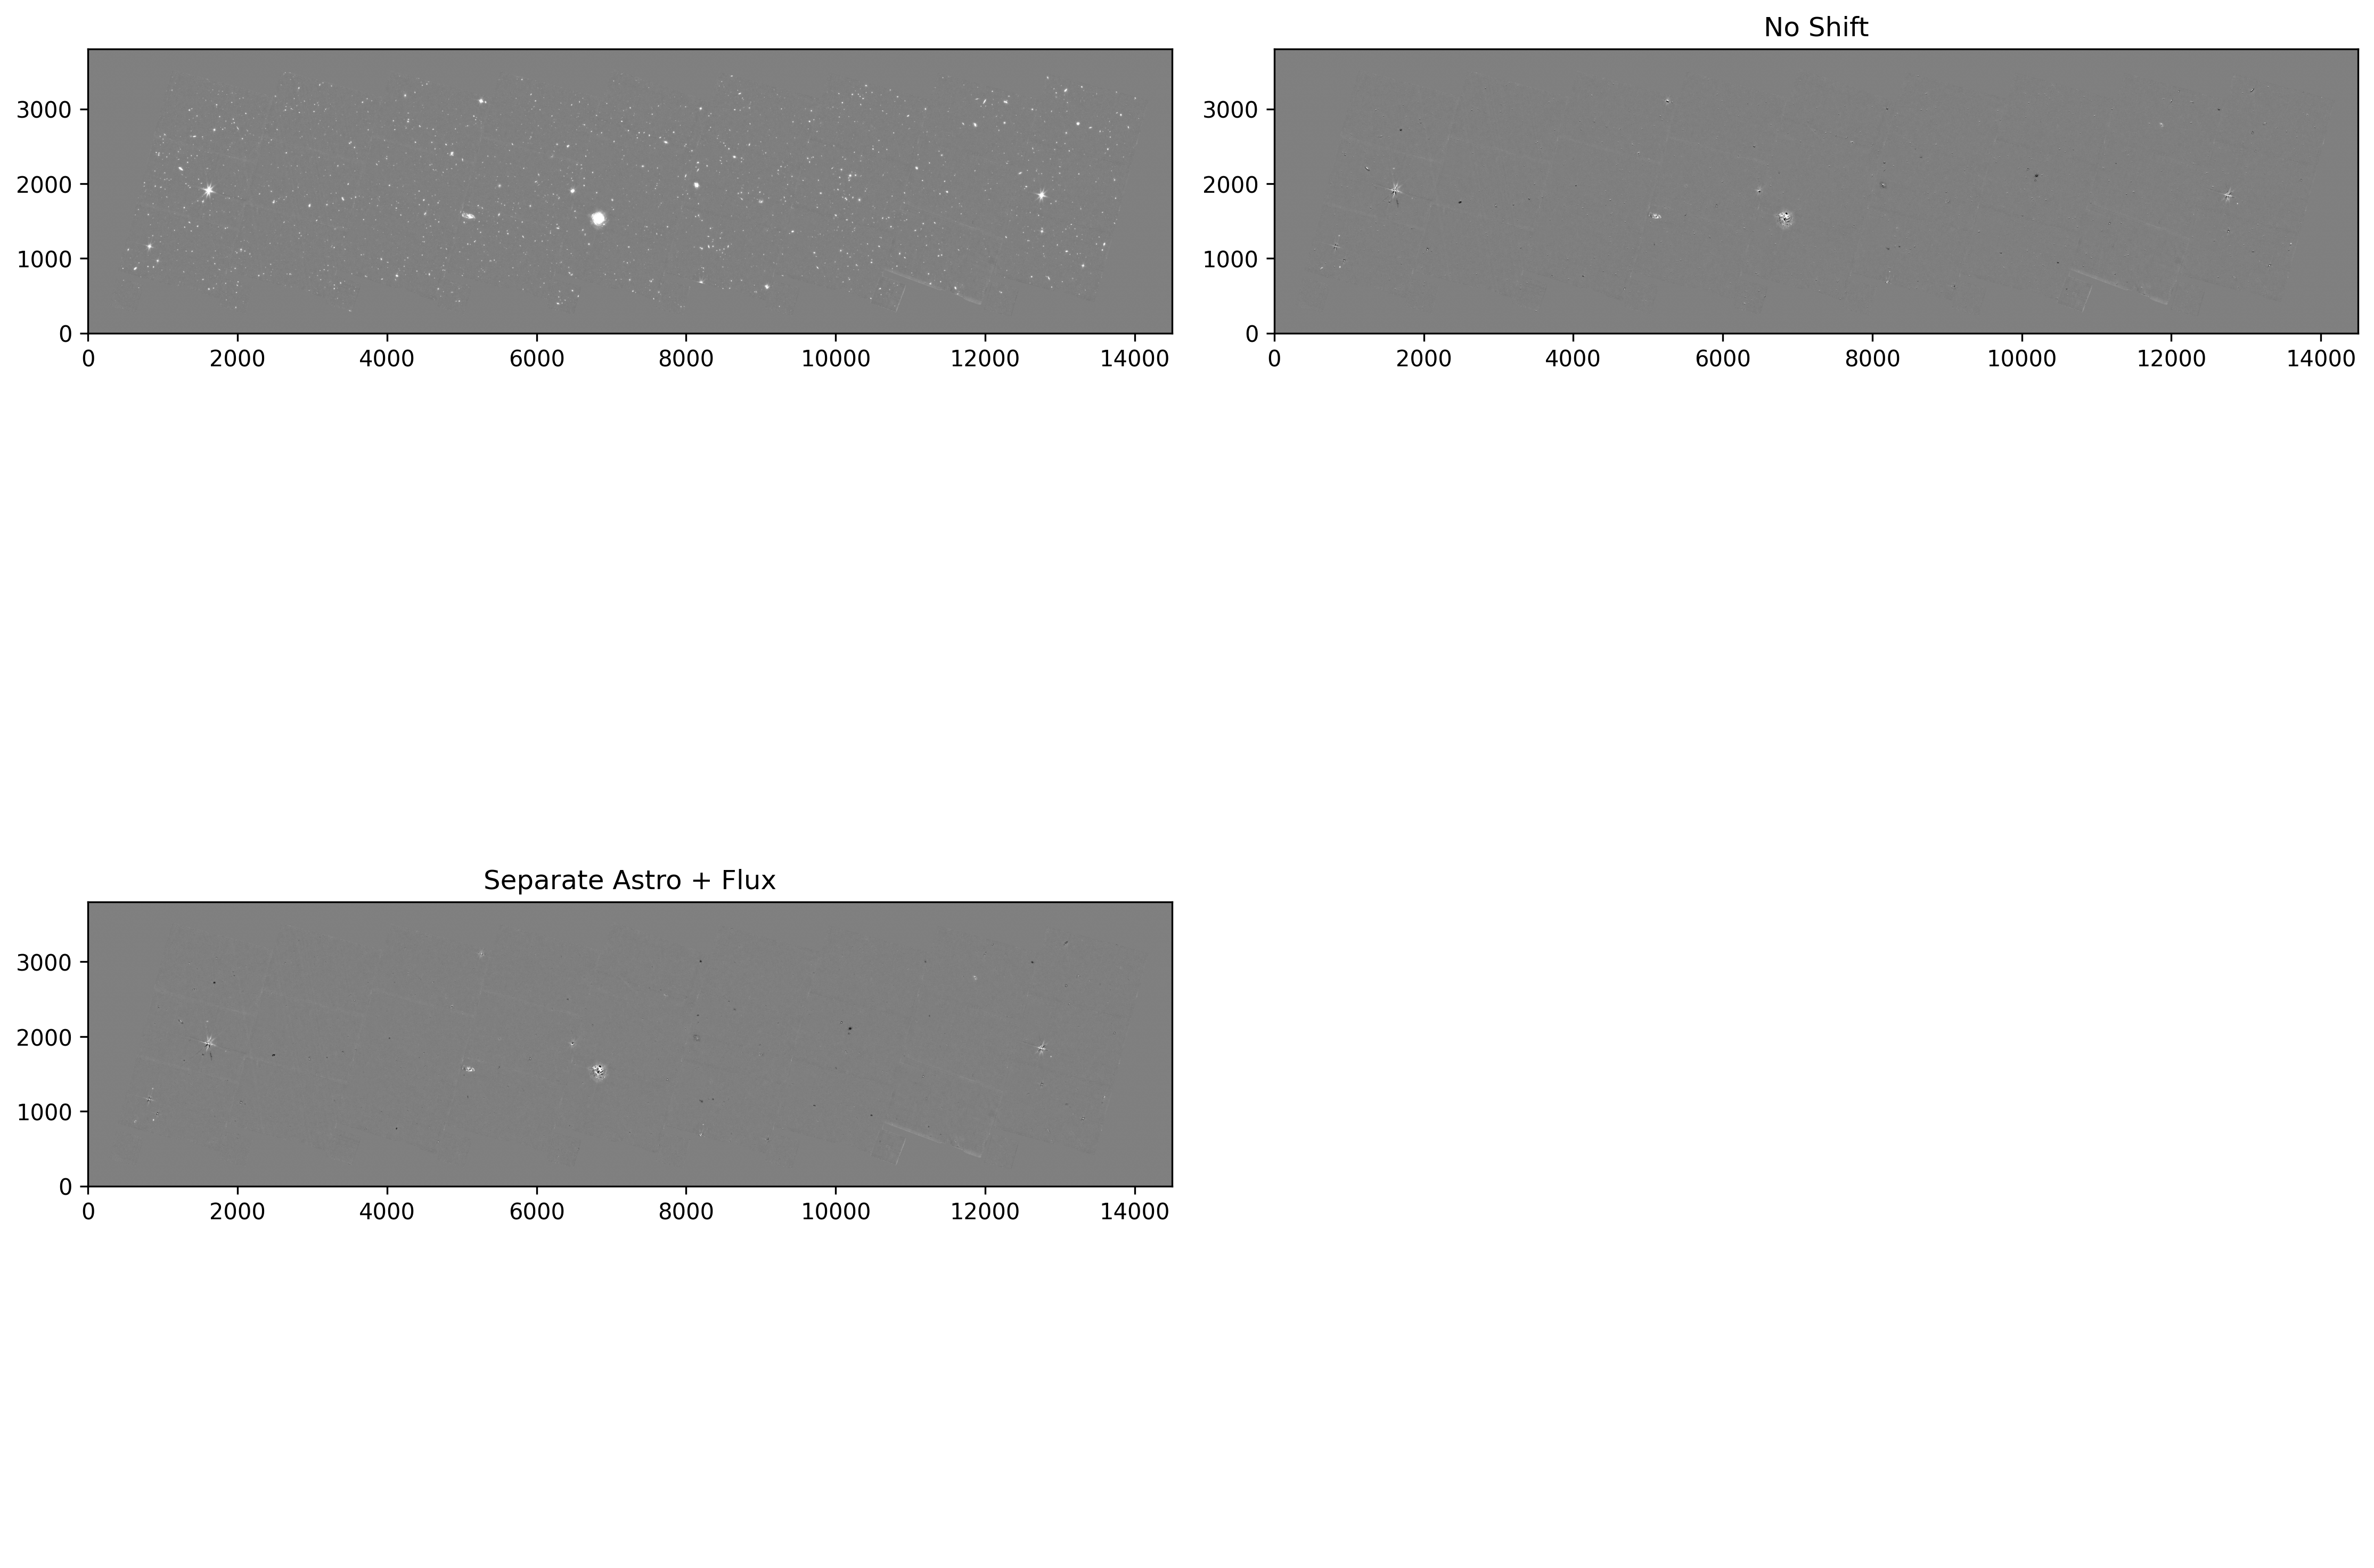

In [29]:
from matplotlib import pyplot as plt
#kbin = round(dpsf_770.driz_pscale/dpsf_444.driz_pscale)
kbin=1
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
titles= ['No Shift', 'Separate Astro + Flux', 'Joint Astro + Flux']
v = 4/kbin**2
ax[0].imshow(cat770.sci, origin='lower', cmap='gray', vmin=-v, vmax=v)
for i in range(3):
    print(i, titles[i])
    if residual[i] is None:
        ax[i + 1].axis('off')  # Hide axis if no residual
        continue
    ax[i + 1].imshow(residual[i], origin='lower', cmap='gray', vmin=-v, vmax=v)
    ax[i + 1].set_title(titles[i])
plt.tight_layout()

0 F444W
1 F770W
2 model F770W
3 residual


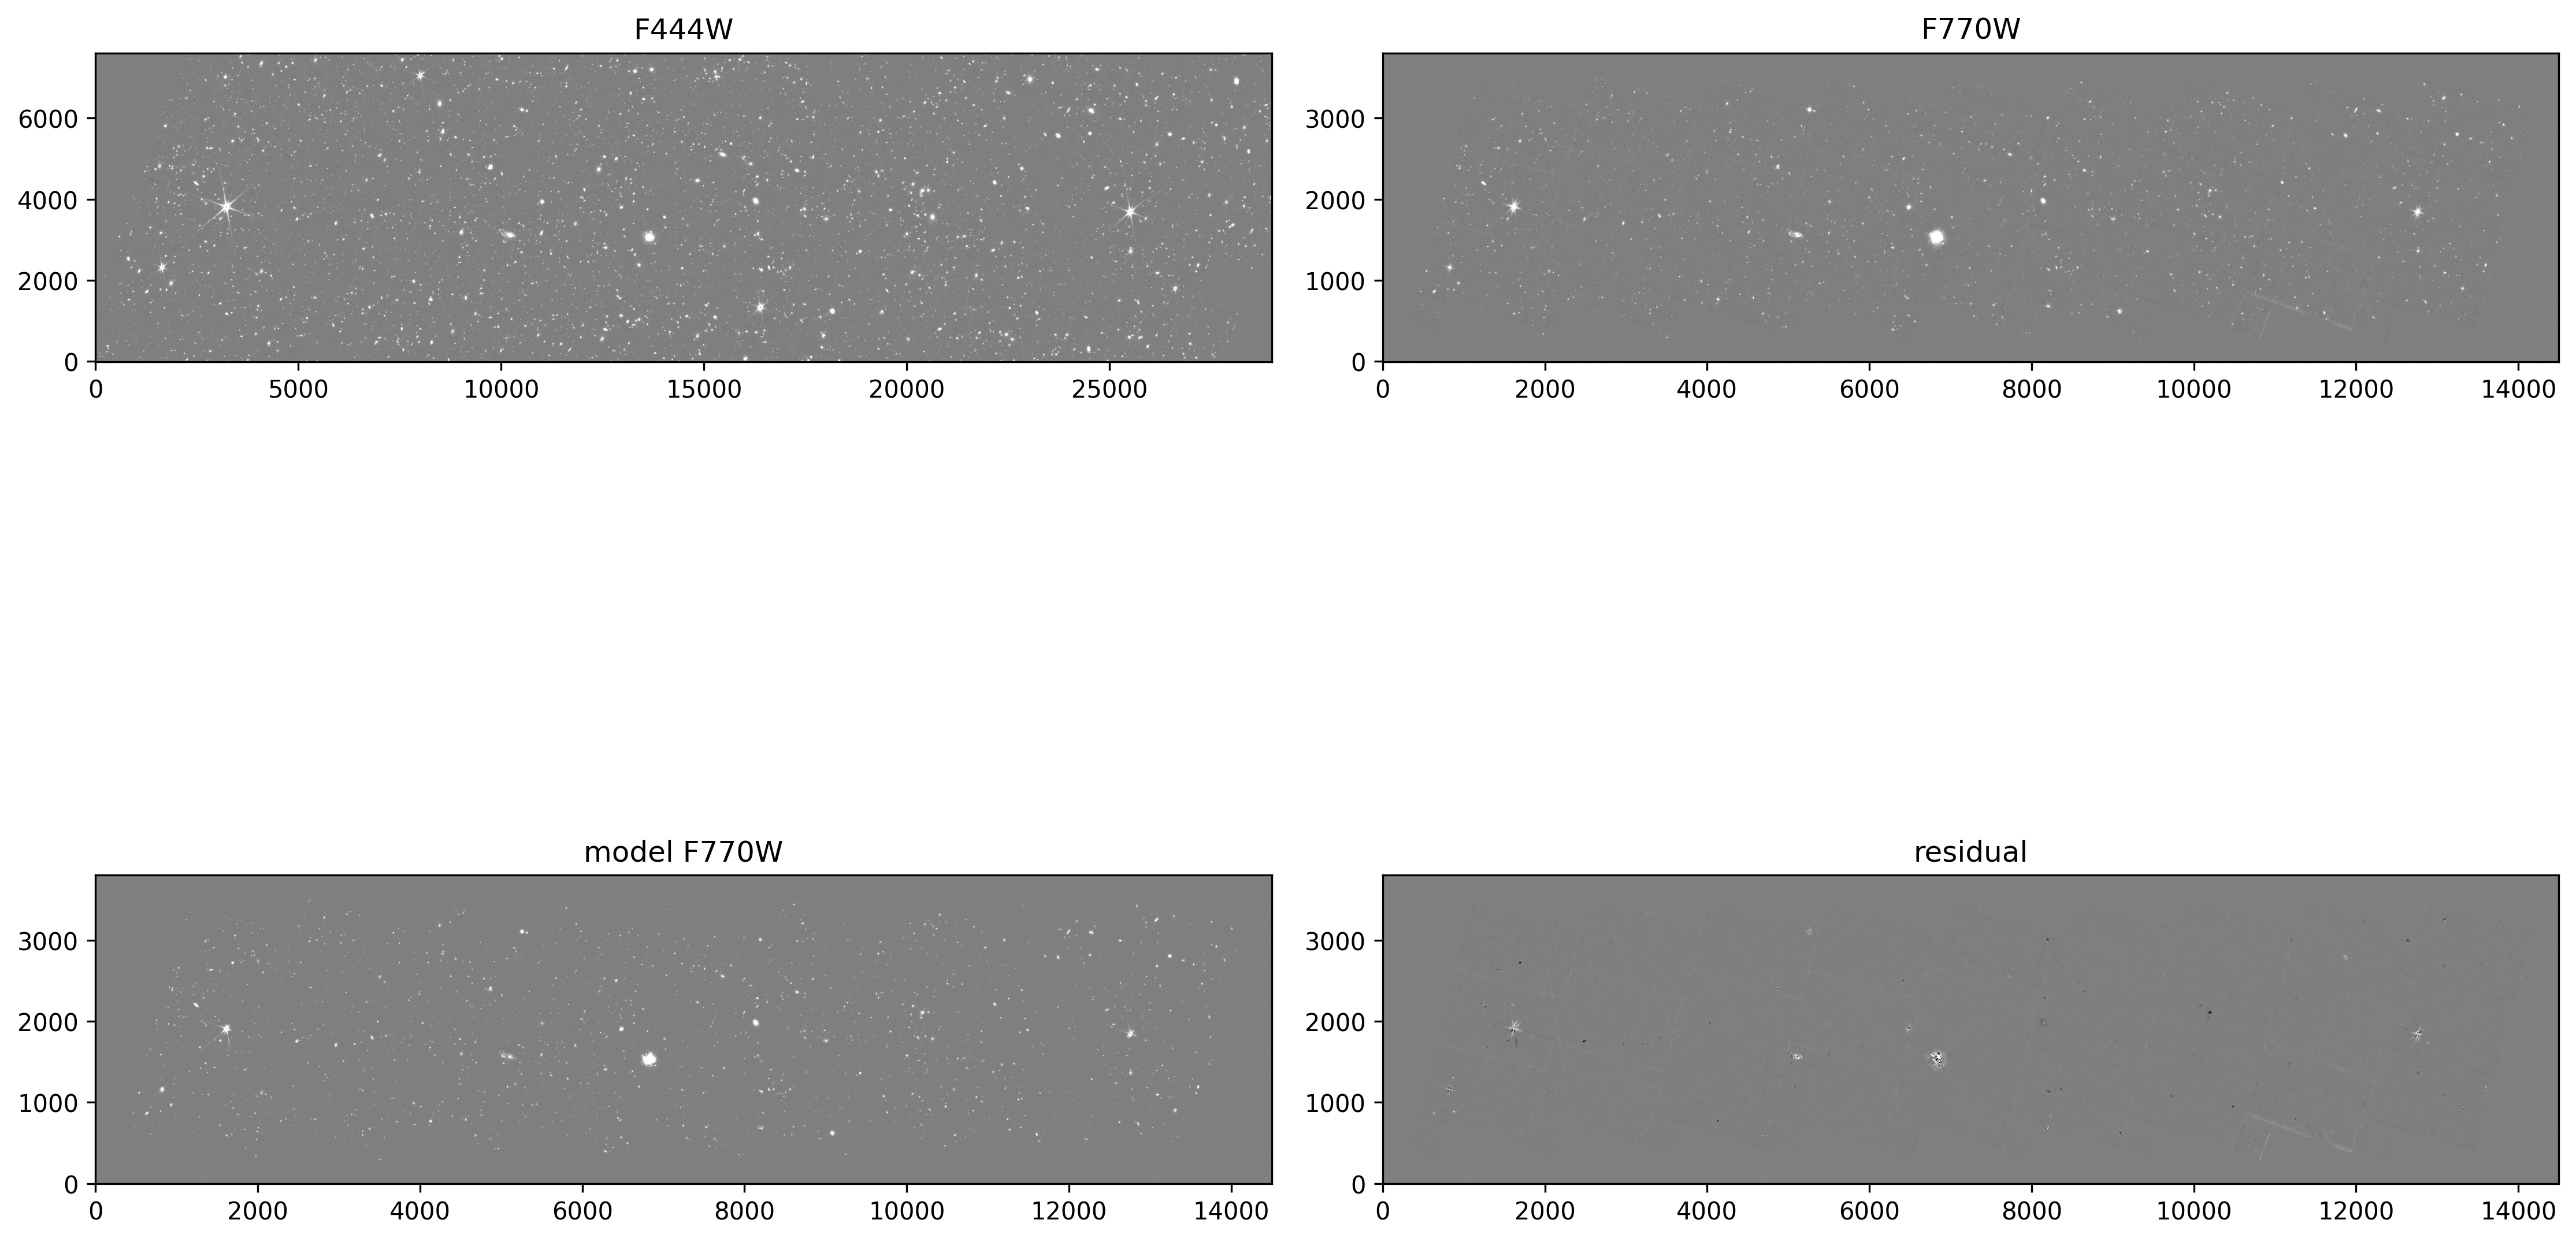

In [35]:
from matplotlib import pyplot as plt
img = [cat444.sci*10, cat770.sci, cat770.sci - residual[1], residual[1]]
titles = ['F444W', 'F770W', 'model F770W', 'residual']
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()
for i in range(4):
    print(i, titles[i])
    ax[i].imshow(img[i], origin='lower', cmap='gray', vmin=-v, vmax=v)
    ax[i].set_title(f'{titles[i]}')
plt.tight_layout()

In [34]:
residual[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3800, 14500))